# Keras - simulated NMR data
### Paul Giesting

##### Summary of my work this week
1. I explored the baseline PyTorch implementation and calculated a version of the custom error metric we'll be graded on, about 0.17 per row of input data.
1. I tried to implement a Keras version of the PyTorch baseline model, but the PyTorch syntax is completely unfamiliar to me and I cannot be sure I'm really getting all that close. The error by the same metric was 0.24.
1. I did some EDA on the dataset and remarked how unrelated the xi, p, and d properties seemed to be to the values of the M curve at the 180 and echo points.
1. I used the autosklearn library and manual exploration to see if non-neural-network solutions could get any traction. The answer was "not really, not in the time alloted" (and I alloted a lot of Tuesday, all of Wednesday, and Thursday until 5 pm, more than made sense). At one point I encountered a k-nearest-neighbors regression via autosklearn that could reproduce some of the alpha behavior but even that was remarkably easy to lose. I cannot reproduce it manually. I noted that random forest and extra tree models at close to baseline configurations would horrendously overtrain (stuff like 0.08 training error and 0.52 test error).
1. I deployed autokeras. I tried implementing the custom error function as the loss and/or metric function in autokeras and while the model would train, it would then refuse to export the structure or compute predictions. I went back to the default loss and metric settings after training with the custom metric, trained again hoping that some of the learned weights would influence the outcome, but I doubt they did. The best I was able to find was a simple-ish model that got down to 0.22 error.

In [1]:
import keras.backend as K
import keras
from keras.models import Model
from keras.layers import Dense, Activation, Dropout, Input
from keras.utils import np_utils
from keras.utils.data_utils import get_file
from keras.utils.vis_utils import model_to_dot, plot_model
from keras.preprocessing import sequence
from keras.optimizers import SGD, RMSprop

In [19]:
from keras.losses import MeanSquaredError
import sklearn.metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [44]:
import kerastuner

In [3]:
# mean version of gross error metric

def weight_mse(truth,predict):
    erf = 0.0
    weight = [0.2, 20, 2, 3]
    for col in range(4):
        erf += sklearn.metrics.mean_squared_error(truth[:,col],predict[:,col]) / (weight[col]**2)
    return erf

In [4]:
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
# dear God, what is wrong with my environment THIS time
import pandas as pd

mat_file = "mat_info.txt"
M_file_r = "echos_r.txt" # real part of echos
M_file_i = "echos_i.txt" # imaginary part of echos
print("Loading into numpy arrays...")
# settings of each simulated material:
# format:  |   α  |   ξ  |   p   |   d   |
mat_info = np.loadtxt(mat_file, comments="#", delimiter='\t', unpack=False);
# M(t) curve for each simulation:
M_r = np.loadtxt(M_file_r, comments="#", delimiter='\t', unpack=False);
M_i = np.loadtxt(M_file_i, comments="#", delimiter='\t', unpack=False);
M = M_r + 1j*M_i;
print("Done with numpy loads")

Loading into numpy arrays...
Done with numpy loads


In [6]:
# partition data into a training and testing set using a random partition
# number of M(t) curves
N_data = np.shape(M)[0]

# pick a 90%/10% split for training/testing
test_frac = 0.10                                # fraction of data to save for testing data
div_idx = int(np.floor((1.0-test_frac)*N_data)) # integer number of curves to use for training
order_seed = np.random.permutation(N_data)      # random ordering for all curves

train_idx = order_seed[0:div_idx]               # first 90% of random order
test_idx = order_seed[div_idx:N_data]           # last 10% of random order

In [7]:
# truncate time points from 210 to 410 in example
# centered roughly at the echo
# let's use whole experiment now
time_keep = range(0,450);

# concatenate the real and imaginary parts together, to make a real-vector of double the length
M_train = M[train_idx[:,None],time_keep]                    # time truncation of input
mat_train = mat_info[train_idx,:]                           # get the output
M_train = np.hstack( (np.real(M_train), np.imag(M_train)) ) # real part, then imaginary part
# is this equivalent to
# M_train = np.hstack(M_r[train_idx],M_i[train_idx])
# ?

# same as above, but for test
M_test = M[test_idx[:,None],time_keep]
mat_test = mat_info[test_idx,:];
M_test = np.hstack( (np.real(M_test), np.imag(M_test)) )

This is the description of the best autokeras model, exported to keras. I have no idea why autokeras inserted a category encoding layer. Since the input data are restricted to -0.5 to 0.5, I don't think a normalization layer is likely to be needed, but it's an option that could be tried later on. If I do that, it looks like I should `adapt` the layer to the training data, or possibly the whole training+validation set, before fitting the whole model.

Ok, step 1: see if I can reproduce the autokeras model without the encoding layer.

In [ ]:
model_description = \
'''Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
input_1 (InputLayer)         [(None, 900)]             0         
_________________________________________________________________
multi_category_encoding (Mul (None, 900)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                28832     
_________________________________________________________________
re_lu (ReLU)                 (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
re_lu_1 (ReLU)               (None, 32)                0         
_________________________________________________________________
regression_head_1 (Dense)    (None, 4)                 132       
=================================================================
Total params: 30,020
Trainable params: 30,020
Non-trainable params: 0
_________________________________________________________________'''

In [5]:
# scale the material properties consistently
# so that mean squared error is the appropriate metric
scaler = MinMaxScaler()
scaler.fit(mat_info)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [14]:
N = np.shape(M_train[0])[0]

input_layer = Input(shape=(N,))
layer1 = Dense(32,activation='relu')(input_layer)
layer2 = Dense(32,activation='relu')(layer1)
layer3 = Dense(4)(layer2)

model = Model(inputs=input_layer, outputs=layer3)
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 900)]             0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                28832     
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 132       
Total params: 30,020
Trainable params: 30,020
Non-trainable params: 0
_________________________________________________________________


In [34]:
# 'huber_loss' is what I was using to construct the keras analog to PyTorch
# it is not autokeras' default, which was val_loss for one or both
# of the loss function and metric (mse was reported too)
# can't even find that here? yet it should be the default?
# vanilla keras won't take the custom loss metric either
opt = keras.optimizers.SGD(learning_rate=0.005,momentum=0.9)
model.compile(loss='mean_squared_error',optimizer=opt,metrics=['mean_squared_error'])

In [35]:
# number of epochs and batches
# 20 epochs was still dropping the metrics on autokeras
# can't tell from PyTorch OR autokeras what their what the batch size was
# batch size 10 worked a little better than 20, which was somewhat better
# than 50 in my earlier keras exploration
n_epochs = 40
n_batch = 10
# transform the target so that mse is equivalent to the appropriate metric
print('Starting Training')
model.fit(M_train,scaler.transform(mat_train),epochs=n_epochs,batch_size=n_batch)
print('Finished Training')

Starting Training
Epoch 1/40
900/900 [==============================] - 1s 2ms/step - loss: 0.0506 - mean_squared_error: 0.0506
Epoch 2/40
900/900 [==============================] - 1s 2ms/step - loss: 0.0501 - mean_squared_error: 0.0501
Epoch 3/40
900/900 [==============================] - 1s 1ms/step - loss: 0.0495 - mean_squared_error: 0.0495
Epoch 4/40
900/900 [==============================] - 1s 1ms/step - loss: 0.0491 - mean_squared_error: 0.0491
Epoch 5/40
900/900 [==============================] - 1s 2ms/step - loss: 0.0484 - mean_squared_error: 0.0484
Epoch 6/40
900/900 [==============================] - 1s 1ms/step - loss: 0.0480 - mean_squared_error: 0.0480
Epoch 7/40
900/900 [==============================] - 1s 2ms/step - loss: 0.0474 - mean_squared_error: 0.0474
Epoch 8/40
900/900 [==============================] - 1s 2ms/step - loss: 0.0467 - mean_squared_error: 0.0467
Epoch 9/40
900/900 [==============================] - 1s 1ms/step - loss: 0.0462 - mean_squared_error:

In [36]:
mat_train_predict = scaler.inverse_transform(model.predict(M_train,batch_size=n_batch))
mat_predict = scaler.inverse_transform(model.predict(M_test,batch_size=n_batch))
print('Training score for model ',weight_mse(mat_train,mat_train_predict))
print('Test score for model ',weight_mse(mat_test,mat_predict))

Training score for model  0.14181771689758704
Test score for model  0.13789912161340212


That seems to have done something. Egads. Let's plot that.

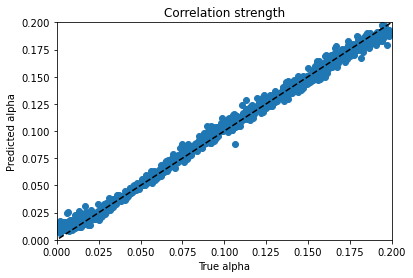

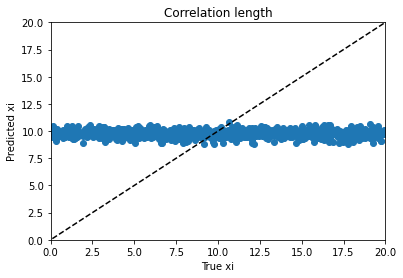

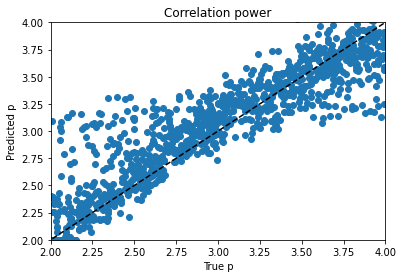

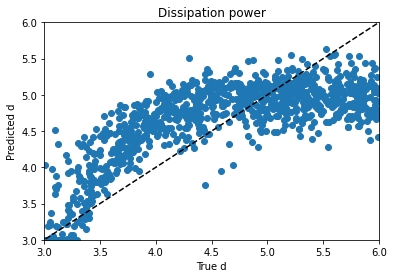

In [37]:
plt.scatter(mat_test[:,0],mat_predict[:,0]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True alpha");
plt.ylabel("Predicted alpha");
plt.axis([0, .2, 0, .2])
plt.title("Correlation strength")

plt.figure()
plt.scatter(mat_test[:,1],mat_predict[:,1]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True xi");
plt.ylabel("Predicted xi");
plt.axis([0, 20, 0, 20])
plt.title("Correlation length")

plt.figure()
plt.scatter(mat_test[:,2],mat_predict[:,2]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True p");
plt.ylabel("Predicted p");
plt.axis([2, 4, 2, 4])
plt.title("Correlation power")

plt.figure()
plt.scatter(mat_test[:,3],mat_predict[:,3]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True d");
plt.ylabel("Predicted d");
plt.axis([3, 6, 3, 6]);
plt.title("Dissipation power");

It's late Friday morning and my model is ALMOST to the point of the baseline. Whatever. We barely grazed deep learning in my bootcamp and I didn't engage with it seriously prior to this week.

(I then went back and increased learning rate from 0.001 to 0.005 and ran for 40 epochs. Now it's an actual improvement!)

Then let's try normalizing the targets instead of compressing them to [0,1].

In [30]:
input2_layer = Input(shape=(N,))
layer21 = Dense(32,activation='relu')(input2_layer)
layer22 = Dense(32,activation='relu')(layer21)
layer23 = Dense(4)(layer22)

model2 = Model(inputs=input2_layer, outputs=layer23)
model2.summary()

Model: "functional_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 900)]             0         
_________________________________________________________________
dense_12 (Dense)             (None, 32)                28832     
_________________________________________________________________
dense_13 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_14 (Dense)             (None, 4)                 132       
Total params: 30,020
Trainable params: 30,020
Non-trainable params: 0
_________________________________________________________________


In [31]:
# scale the material properties consistently
normer = StandardScaler()
normer.fit(mat_info)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [38]:
opt = keras.optimizers.SGD(learning_rate=0.005,momentum=0.9)
model2.compile(loss='mean_squared_error',optimizer=opt,metrics=['mean_squared_error'])

In [39]:
# number of epochs and batches
n_epochs = 40
n_batch = 10
# transform the target; mse is not quite the appropriate metric now but still close
print('Starting Training')
model2.fit(M_train,normer.transform(mat_train),epochs=n_epochs,batch_size=n_batch)
print('Finished Training')

Starting Training
Epoch 1/40
900/900 [==============================] - 1s 2ms/step - loss: 0.5640 - mean_squared_error: 0.5640
Epoch 2/40
900/900 [==============================] - 1s 1ms/step - loss: 0.5415 - mean_squared_error: 0.5415
Epoch 3/40
900/900 [==============================] - 1s 1ms/step - loss: 0.5211 - mean_squared_error: 0.5211
Epoch 4/40
900/900 [==============================] - 1s 2ms/step - loss: 0.5076 - mean_squared_error: 0.5076
Epoch 5/40
900/900 [==============================] - 1s 2ms/step - loss: 0.5008 - mean_squared_error: 0.5008
Epoch 6/40
900/900 [==============================] - 1s 1ms/step - loss: 0.4965 - mean_squared_error: 0.4965
Epoch 7/40
900/900 [==============================] - 1s 2ms/step - loss: 0.4850 - mean_squared_error: 0.4850
Epoch 8/40
900/900 [==============================] - 1s 2ms/step - loss: 0.4772 - mean_squared_error: 0.4772
Epoch 9/40
900/900 [==============================] - 1s 2ms/step - loss: 0.4732 - mean_squared_error:

In [40]:
mat2_train_predict = normer.inverse_transform(model2.predict(M_train,batch_size=n_batch))
mat2_predict = normer.inverse_transform(model2.predict(M_test,batch_size=n_batch))
print('Training score for model ',weight_mse(mat_train,mat2_train_predict))
print('Test score for model ',weight_mse(mat_test,mat2_predict))

Training score for model  0.16133084616711393
Test score for model  0.15742218232789149


Let's plot that.

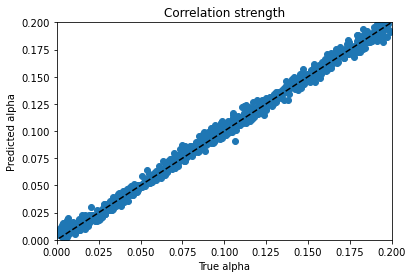

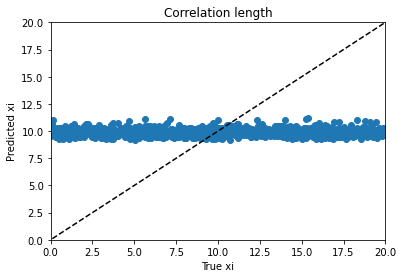

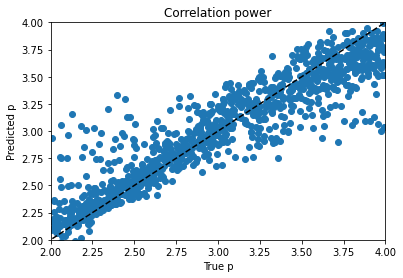

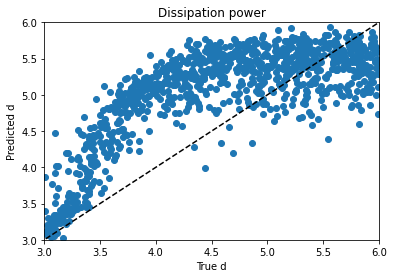

In [41]:
plt.scatter(mat_test[:,0],mat2_predict[:,0]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True alpha");
plt.ylabel("Predicted alpha");
plt.axis([0, .2, 0, .2])
plt.title("Correlation strength")

plt.figure()
plt.scatter(mat_test[:,1],mat2_predict[:,1]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True xi");
plt.ylabel("Predicted xi");
plt.axis([0, 20, 0, 20])
plt.title("Correlation length")

plt.figure()
plt.scatter(mat_test[:,2],mat2_predict[:,2]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True p");
plt.ylabel("Predicted p");
plt.axis([2, 4, 2, 4])
plt.title("Correlation power")

plt.figure()
plt.scatter(mat_test[:,3],mat2_predict[:,3]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True d");
plt.ylabel("Predicted d");
plt.axis([3, 6, 3, 6]);
plt.title("Dissipation power");

Fascinating and weird.

I could introduce some dropout to regularize features.

Another step would be to introduce an RNN layer as we saw at Metis.

Also worth checking using only Im(M) for input.

Obviously I could also tinker with the width of layers and number of layers.

Keras has the Tuner to fit structure and hyperparameters, too. Let's go back and follow that methodology.

In [47]:
def build_model(hp):
    inputs = Input(shape=(N,))
    x = Dense(
        units = hp.Int('units',min_value=32,max_value=512,step=32),
        activation='relu'
    )(inputs)
    y = Dense(
        units = hp.Int('units',min_value=16,max_value=128,step=16),
        activation='relu'
    )(x)
    outputs = Dense(4)(y)
    model = Model(inputs, outputs)
    opt = keras.optimizers.SGD(
        hp.Choice('learning_rate',
                 values=[0.01,0.005,0.001]),
        hp.Choice('momentum',
                 values=[0.67,0.9,0.95])
    )
    model.compile(loss='mean_squared_error',optimizer=opt,metrics=['mean_squared_error'])
    return model

In [48]:
tuner = kerastuner.tuners.Hyperband(
        build_model,
        objective='mean_squared_error',
        max_epochs=100,
        executions_per_trial=2,
        directory='keras_tune'
)

In [ ]:
print('Starting Tuning')
tuner.search(M_train,scaler.transform(mat_train),
             validation_data=(M_test,mat_test))
print('Finished Tuning')

Trial 137 Complete [00h 00m 40s]
mean_squared_error: 0.047165123745799065

Best mean_squared_error So Far: 0.046272074803709984
Total elapsed time: 00h 28m 06s

Search: Running Trial #138

Hyperparameter    |Value             |Best Value So Far 
units             |256               |512               
learning_rate     |0.01              |0.01              
momentum          |0.95              |0.95              
tuner/epochs      |12                |12                
tuner/initial_e...|4                 |4                 
tuner/bracket     |4                 |4                 
tuner/round       |2                 |2                 
tuner/trial_id    |7c66b55ee09be46...|c2c89310ee9cc2b...

Epoch 5/12
282/282 [==============================] - 2s 6ms/step - loss: 0.0696 - mean_squared_error: 0.0696 - val_loss: 37.6884 - val_mean_squared_error: 37.6884
Epoch 6/12
282/282 [==============================] - 2s 6ms/step - loss: 0.0562 - mean_squared_error: 0.0562 - val_loss: 37.4547 - v

In [17]:
mat_train_predict = scaler.inverse_transform(model.predict(M_train,batch_size=n_batch))
mat_predict = scaler.inverse_transform(model.predict(M_test,batch_size=n_batch))
print('Training score for model ',weight_mse(mat_train,mat_train_predict))
print('Test score for model ',weight_mse(mat_test,mat_predict))

Training score for model  0.20037383791327928
Test score for model  0.19572464629749206


That seems to have done something. Egads. Let's plot that.

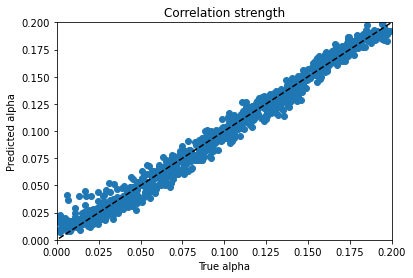

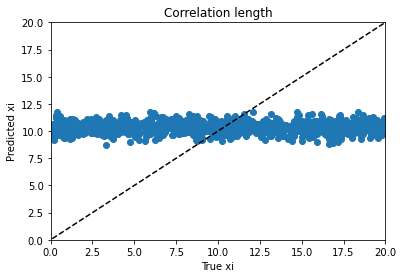

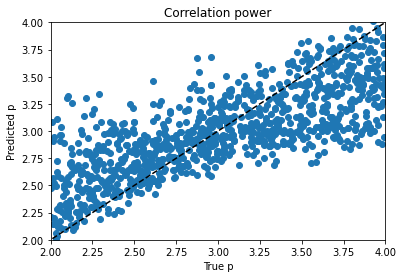

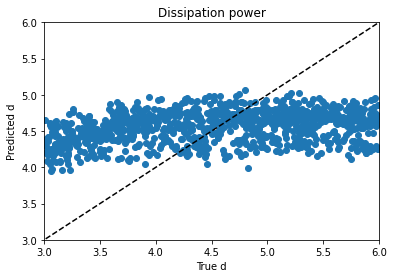

In [18]:
plt.scatter(mat_test[:,0],mat_predict[:,0]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True alpha");
plt.ylabel("Predicted alpha");
plt.axis([0, .2, 0, .2])
plt.title("Correlation strength")

plt.figure()
plt.scatter(mat_test[:,1],mat_predict[:,1]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True xi");
plt.ylabel("Predicted xi");
plt.axis([0, 20, 0, 20])
plt.title("Correlation length")

plt.figure()
plt.scatter(mat_test[:,2],mat_predict[:,2]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True p");
plt.ylabel("Predicted p");
plt.axis([2, 4, 2, 4])
plt.title("Correlation power")

plt.figure()
plt.scatter(mat_test[:,3],mat_predict[:,3]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True d");
plt.ylabel("Predicted d");
plt.axis([3, 6, 3, 6]);
plt.title("Dissipation power");